In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load data
passing_cleaned = pd.read_csv('passing_cleaned.csv')
nfl_league_master = pd.read_csv('NFL_League_Master.csv')
team_name_abbreviations = pd.read_excel('Team name abbreviations.xlsx')

# Map full team names to abbreviations
team_map = dict(zip(team_name_abbreviations['Full Team Name'], team_name_abbreviations['Abbreviation']))
nfl_league_master['Tm'] = nfl_league_master['NFL Team'].map(team_map)

# Merge datasets
merged_data = pd.merge(passing_cleaned, nfl_league_master, on=['Tm', 'Year'], how='inner')

# Data cleaning - remove non-numeric columns excluding the team names
columns_to_remove = ['Player', 'NFL Team', 'Home', 'Road', 'Div', 'Conf', 'Non-Conf', 'Strk', 'Last 5', 'Unnamed: 0_x', 'Unnamed: 0_y']
merged_data = merged_data.drop(columns=columns_to_remove, errors='ignore')
print(merged_data.columns)

# One-hot encoding for team abbreviations
merged_data_encoded = pd.get_dummies(merged_data, columns=['Tm'])
print(merged_data_encoded.columns)

# Define X and Y
Y = merged_data_encoded['Rate']
X = merged_data_encoded.drop(['Rate'], axis=1)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Index(['Tm', 'Age', 'G', 'GS', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'TD%', 'Int',
       'Int%', '1D', 'Lng', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate', 'Sk', 'Yds-s',
       'Sk%', 'NY/A', 'ANY/A', 'Year', 'W', 'L', 'T', 'PCT', 'PF', 'PA',
       'Net Pts', 'Pct', 'Pct.1'],
      dtype='object')
Index(['Age', 'G', 'GS', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'TD%', 'Int',
       'Int%', '1D', 'Lng', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate', 'Sk', 'Yds-s',
       'Sk%', 'NY/A', 'ANY/A', 'Year', 'W', 'L', 'T', 'PCT', 'PF', 'PA',
       'Net Pts', 'Pct', 'Pct.1', 'Tm_ARI', 'Tm_ATL', 'Tm_BAL', 'Tm_BUF',
       'Tm_CAR', 'Tm_CHI', 'Tm_CIN', 'Tm_CLE', 'Tm_DAL', 'Tm_DEN', 'Tm_DET',
       'Tm_GNB', 'Tm_HOU', 'Tm_IND', 'Tm_JAX', 'Tm_KAN', 'Tm_LAC', 'Tm_LAR',
       'Tm_LVR', 'Tm_MIA', 'Tm_MIN', 'Tm_NOR', 'Tm_NWE', 'Tm_NYG', 'Tm_NYJ',
       'Tm_PHI', 'Tm_PIT', 'Tm_SEA', 'Tm_SFO', 'Tm_TAM', 'Tm_TEN', 'Tm_WAS'],
      dtype='object')


In [74]:
# List of some effective features to be used to derive outliers and histograms later in the project
sample_features = ['Cmp%', 'Yds', 'TD', 'Int', 'Lng', 'Y/A']


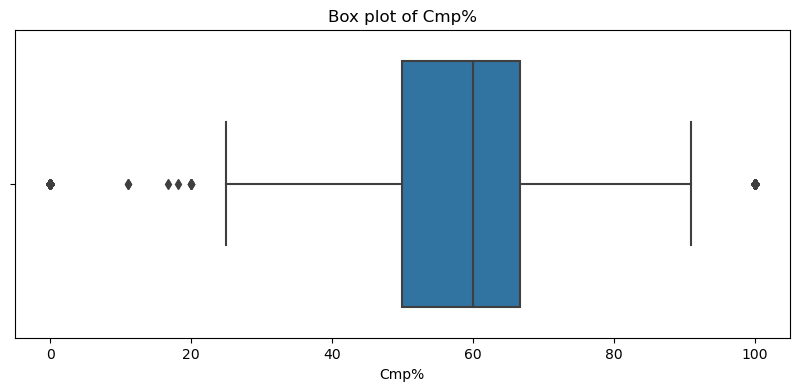

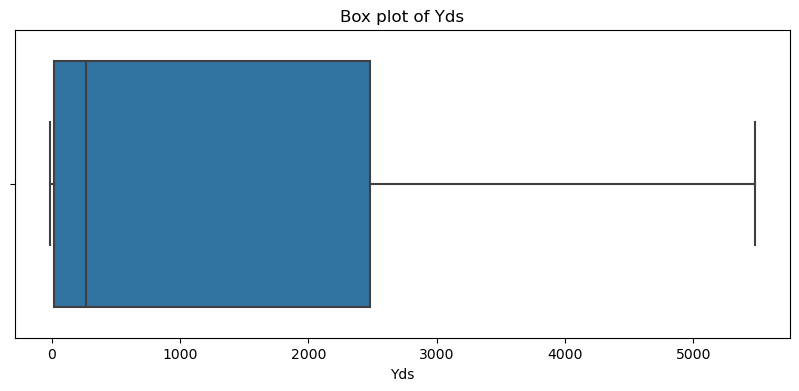

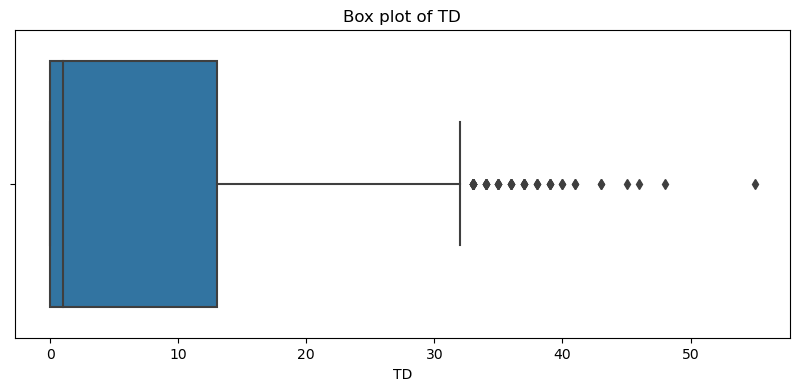

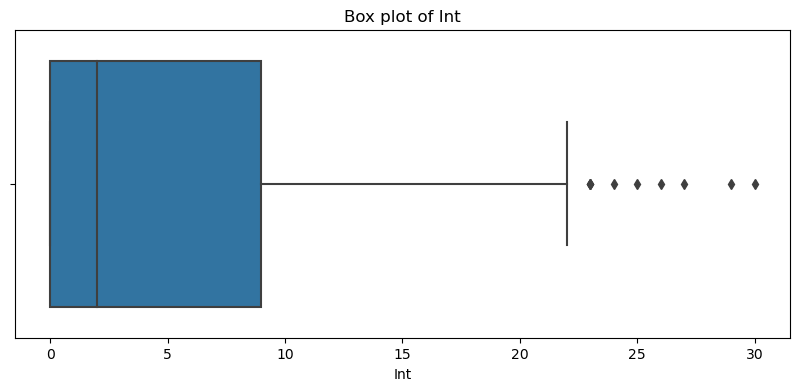

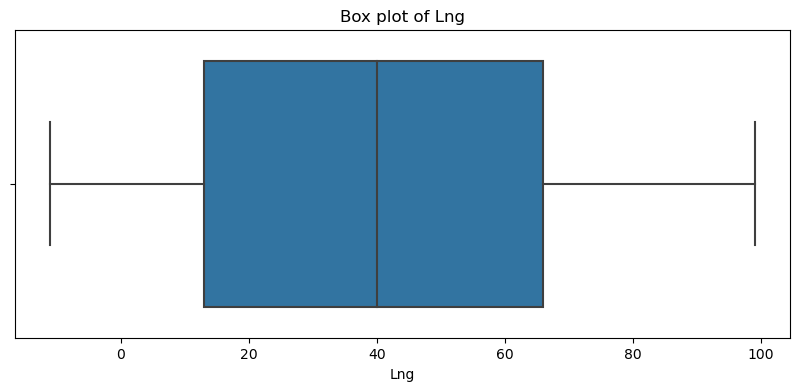

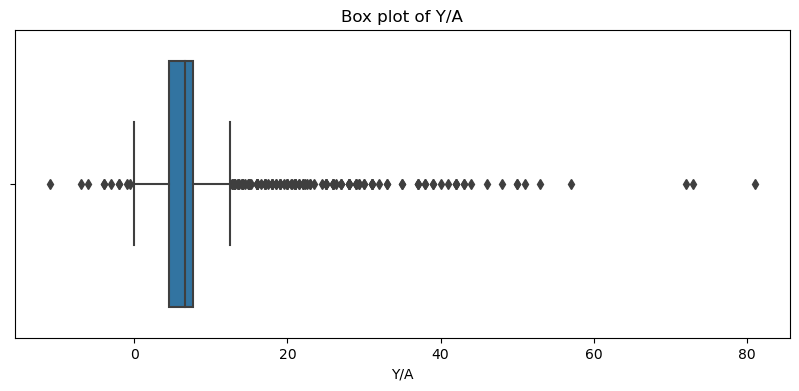

In [75]:
# Box plots to identify outliers
for feature in sample_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=X_train[feature])
    plt.title(f'Box plot of {feature}')
    plt.xlabel(feature)
    plt.show()

In [76]:
# Calculating variance for each numerical feature
variance = X_train.var()

# Display the variance
print(variance.sort_values(ascending=False).head(10))

# As the data points are widely spread out, you can see the high variance values as displayed below indicating a 
# high variance estimate. We believe, each data point in the dataset is important and couldn't be eliminated based on
# outliers result or any other, which may indirectly result in high MSE.

Yds        2.416366e+06
Att        4.549759e+04
Cmp        1.826834e+04
Y/G        1.091908e+04
Net Pts    1.033374e+04
Yds-s      9.372661e+03
1D         5.768400e+03
PF         4.939070e+03
PA         3.812652e+03
Lng        8.409943e+02
dtype: float64


In [77]:
# Model fitting
model = LinearRegression()
model.fit(X_train, Y_train)

# Predictions
Y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("RMSE :", rmse)

# Feature Importance
feature_importance = pd.Series(model.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
print('Most significant features:')
print(feature_importance.head(10))

RMSE : 11.815380157358414
Most significant features:
PCT       245.386846
AY/A       31.147241
Y/A       -28.167863
Int%       12.898250
L           7.537771
W          -7.285590
Pct.1      -6.039159
TD%        -5.530095
Tm_MIA      4.577720
Tm_WAS      4.342206
dtype: float64


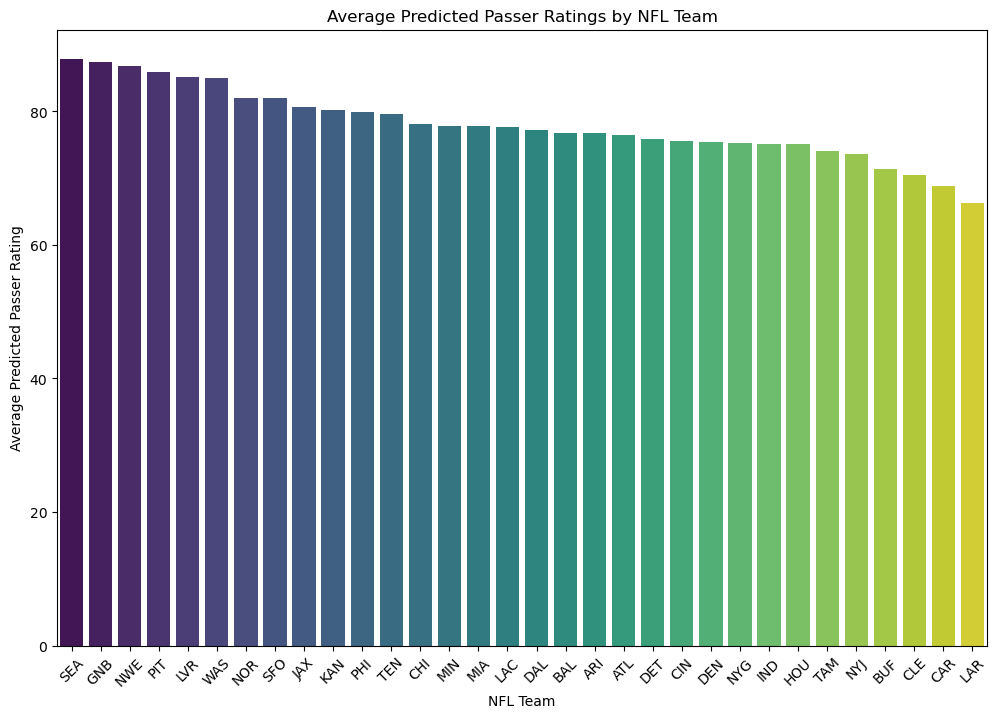

In [78]:

# Make predictions and append a column
merged_data['Predicted Rating'] = model.predict(X)

# Aggregate the data by team to compute the average predicted ratings
team_ratings = merged_data.groupby('Tm')['Predicted Rating'].mean().reset_index()

# Sort the data for better visualization
team_ratings = team_ratings.sort_values(by='Predicted Rating', ascending=False)

# Plotting the data
plt.figure(figsize=(12, 8))
sns.barplot(x='Tm', y='Predicted Rating', data=team_ratings, palette='viridis')
plt.title('Average Predicted Passer Ratings by NFL Team')
plt.xlabel('NFL Team')
plt.ylabel('Average Predicted Passer Rating')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


In [79]:
# Insights into how quarterback efficiency impacts team success and identify trends or patterns across different teams.

# Calculate average passer ratings, total wins, and losses per team per year
team_performance = merged_data.groupby(['Tm', 'Year']).agg({
    'Predicted Rating': 'mean',  # Average passer rating
    'W': 'sum',  # Total wins
    'L': 'sum'   # Total losses
}).reset_index()

team_performance.rename(columns={'Predicted Rating': 'Average Passer Rating'}, inplace=True)

correlation_matrix = team_performance[['Average Passer Rating', 'W', 'L']].corr()
print(correlation_matrix)


                       Average Passer Rating         W         L
Average Passer Rating               1.000000  0.054472 -0.309141
W                                   0.054472  1.000000 -0.085414
L                                  -0.309141 -0.085414  1.000000


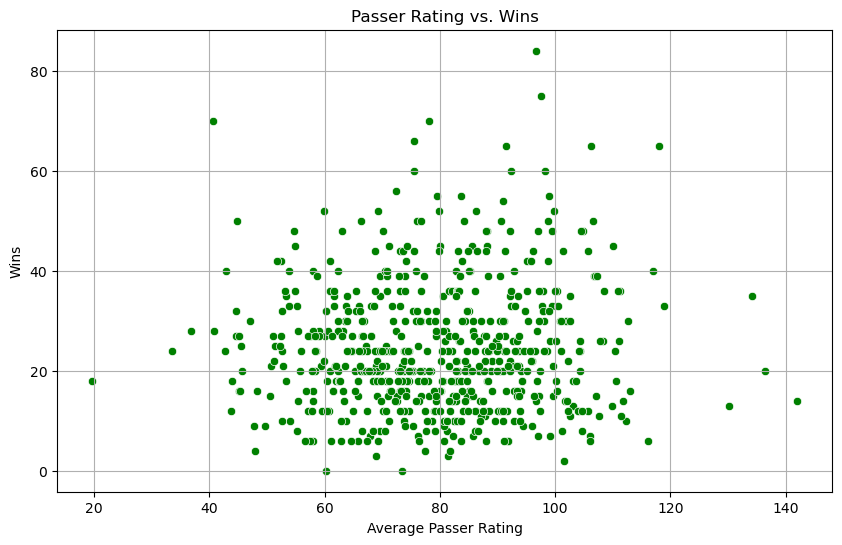

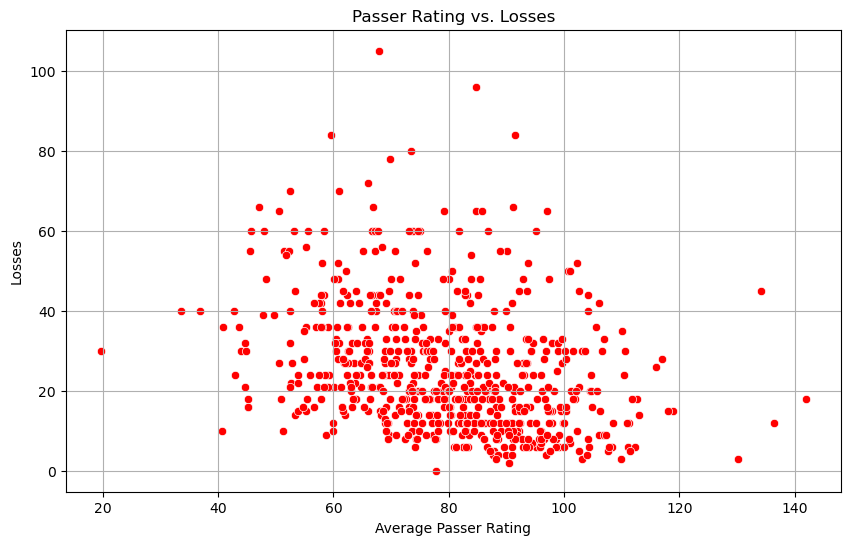

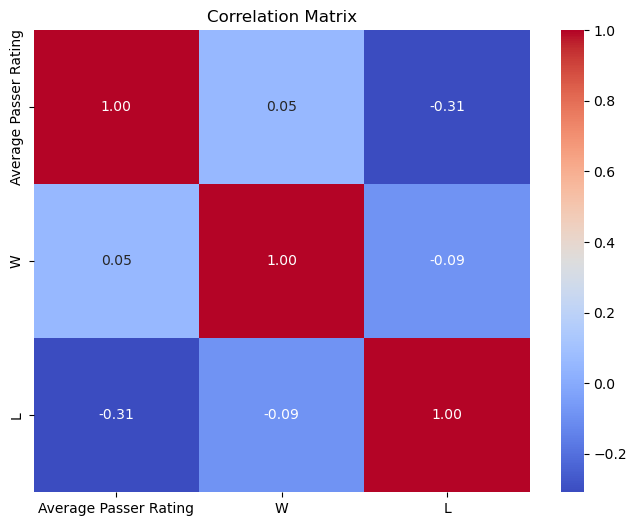

In [80]:
# Scatter plot for Passer Ratings vs Wins
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average Passer Rating', y='W', data=team_performance, color='green')
plt.title('Passer Rating vs. Wins')
plt.xlabel('Average Passer Rating')
plt.ylabel('Wins')
plt.grid(True)
plt.show()

# Scatter plot for Passer Ratings vs Losses
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average Passer Rating', y='L', data=team_performance, color='red')
plt.title('Passer Rating vs. Losses')
plt.xlabel('Average Passer Rating')
plt.ylabel('Losses')
plt.grid(True)
plt.show()

# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

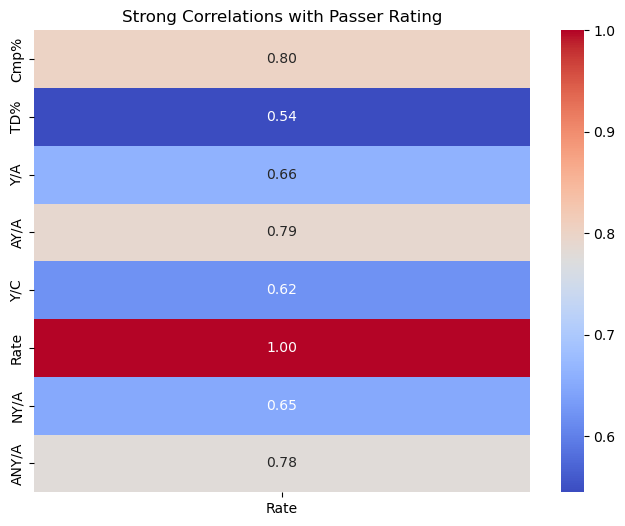

In [81]:
# Calculate the correlation matrix
correlation_matrix = merged_data_encoded.corr()

# Focus on the correlation of features with 'Rate' and filter for strong correlations
strong_correlations = correlation_matrix['Rate'][abs(correlation_matrix['Rate']) > 0.5]

# Visualize the strong correlations of features with 'Rate'
plt.figure(figsize=(8, 6))
sns.heatmap(strong_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Strong Correlations with Passer Rating')
plt.show()

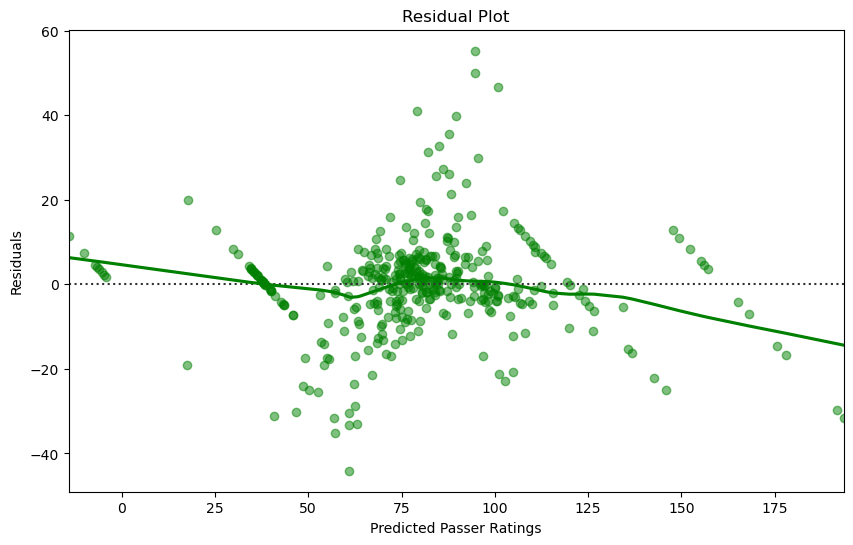

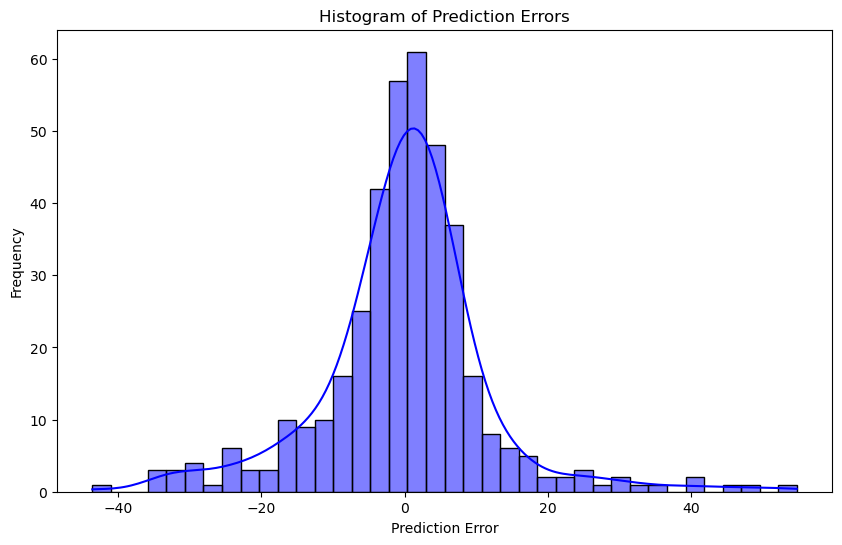

'\nResidual Plot: This plot shows the residuals (differences between actual and predicted values) against the predicted passer ratings. The spread of residuals around the horizontal line at zero can help identify patterns in the prediction errors. Ideally, residuals should be randomly dispersed without forming any discernible patterns.\nHistogram of Prediction Errors: This histogram displays the distribution of the prediction errors. A normally distributed histogram centered around zero suggests that the model is unbiased and its errors are normally distributed, which is a good sign in regression analysis.\n'

In [82]:

# Residual Plot
plt.figure(figsize=(10, 6))
sns.residplot(x=Y_pred, y=residuals, lowess=True, color="g", scatter_kws={'alpha': 0.5})
plt.title('Residual Plot')
plt.xlabel('Predicted Passer Ratings')
plt.ylabel('Residuals')
plt.show()


# Histogram of Prediction Errors
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


'''
Residual Plot: This plot shows the residuals (differences between actual and predicted values) against the predicted passer ratings. The spread of residuals around the horizontal line at zero can help identify patterns in the prediction errors. Ideally, residuals should be randomly dispersed without forming any discernible patterns.
Histogram of Prediction Errors: This histogram displays the distribution of the prediction errors. A normally distributed histogram centered around zero suggests that the model is unbiased and its errors are normally distributed, which is a good sign in regression analysis.
'''

In [83]:
def clamp_values(predictions, min_value=0, max_value=158.3):
    return np.clip(predictions, min_value, max_value)

# Example values for numeric fields
typical_values = {
    'Age': 28, 'G': 16, 'GS': 16, 'Cmp': 350, 'Att': 550,
    'Cmp%': 65, 'Yds': 3800, 'TD': 25, 'Int': 10, 'Lng': 70, 'Y/A': 7
}
for key, value in typical_values.items():
    new_examples[key] = value

# Re-predict using the adjusted synthetic data
adjusted_predictions = model.predict(new_examples)
adjusted_predictions = clamp_values(adjusted_predictions)

# Display adjusted predictions
print('Adjusted Synthetic Predictions:', adjusted_predictions)


Adjusted Synthetic Predictions: [0. 0.]


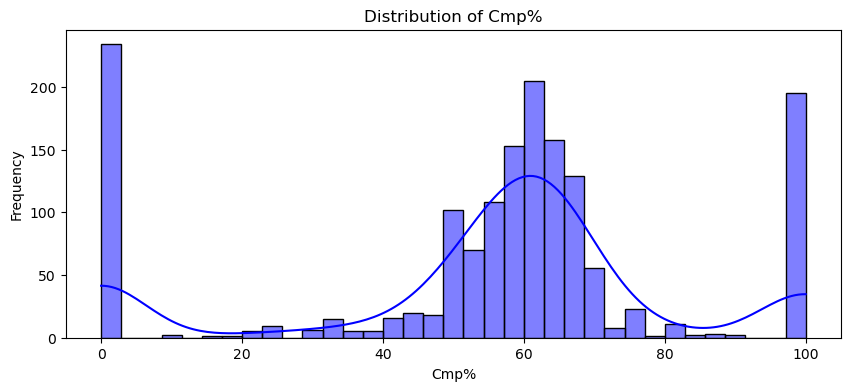

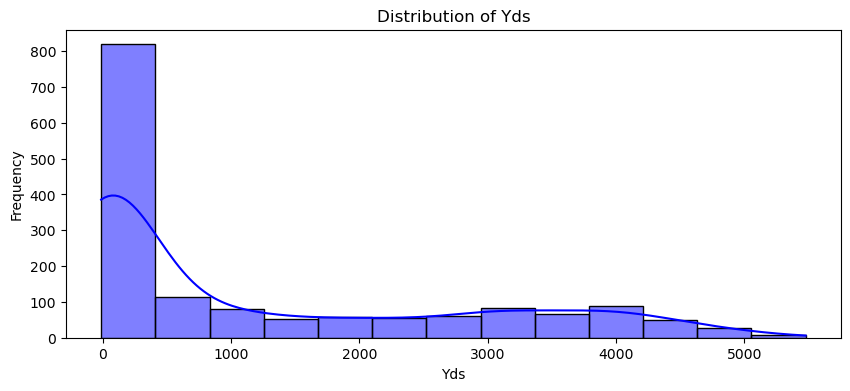

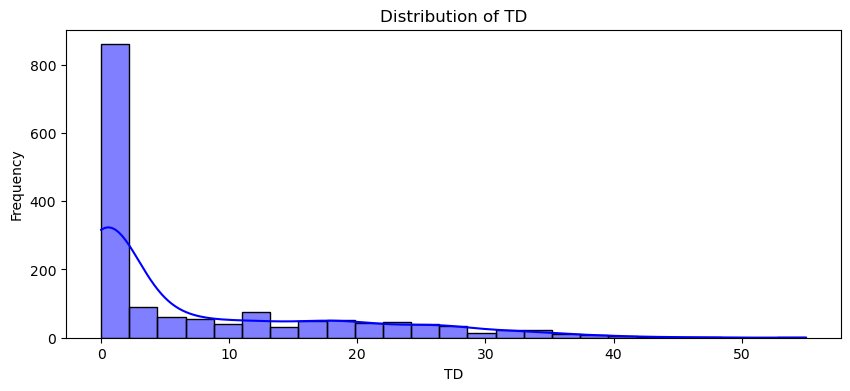

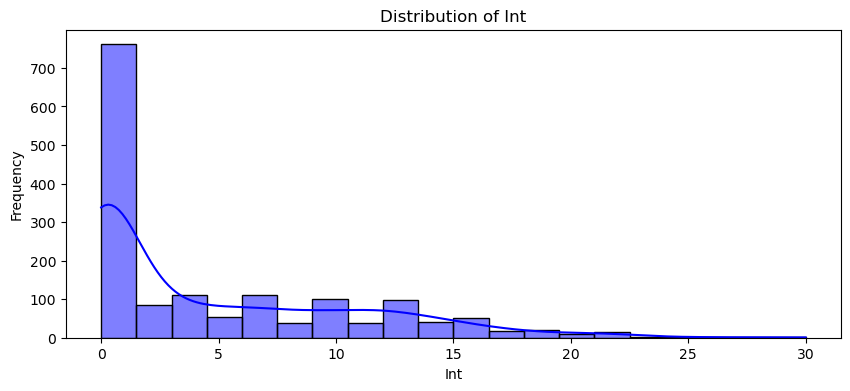

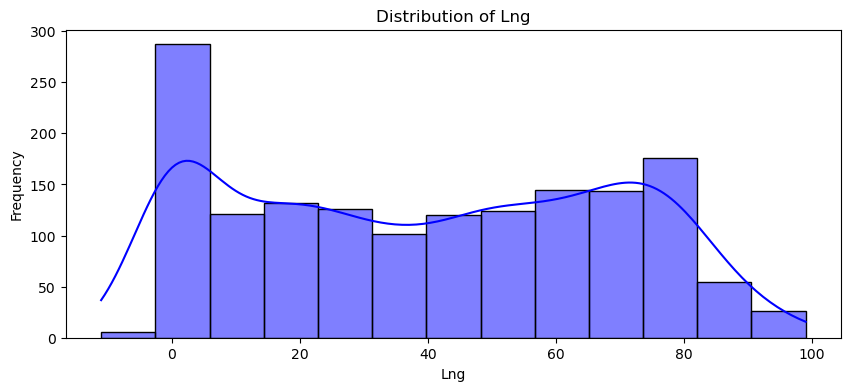

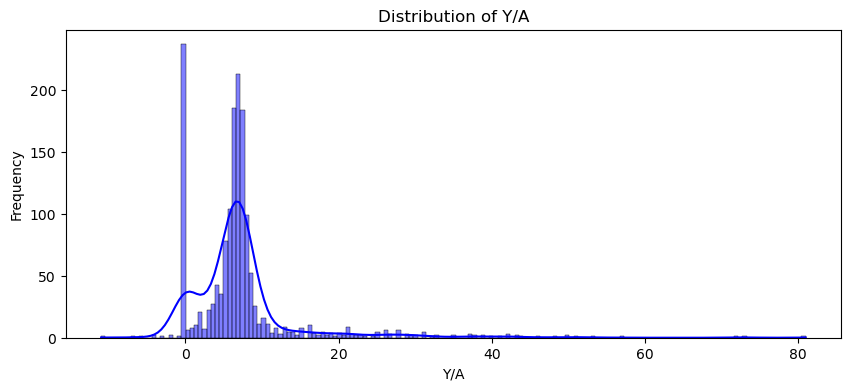

In [84]:
for feature in sample_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(X_train[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


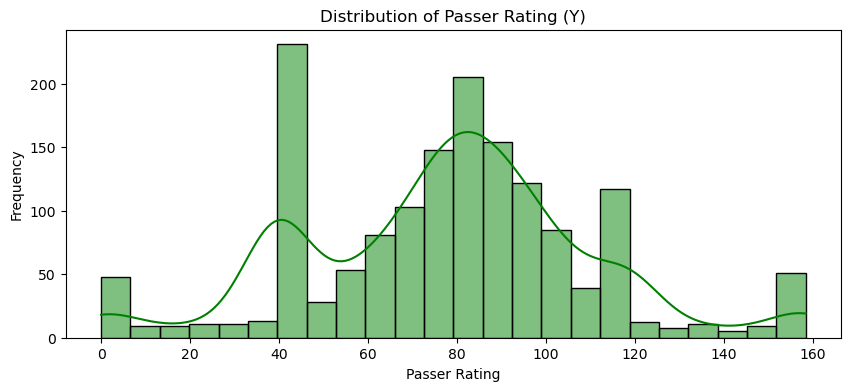

In [85]:

# Distribution of the target variable Y
plt.figure(figsize=(10, 4))
sns.histplot(Y_train, kde=True, color='green')
plt.title('Distribution of Passer Rating (Y)')
plt.xlabel('Passer Rating')
plt.ylabel('Frequency')
plt.show()


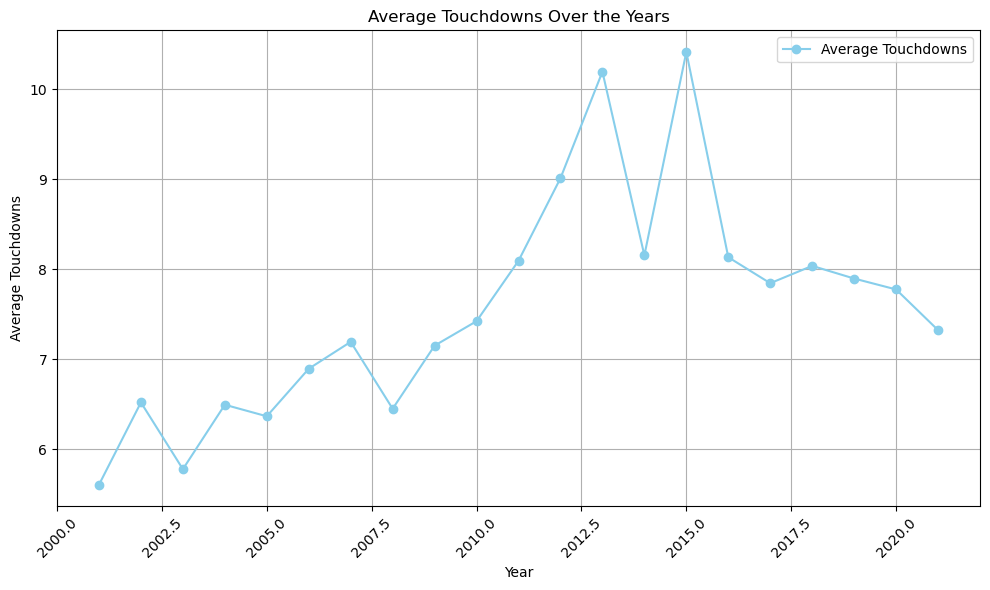

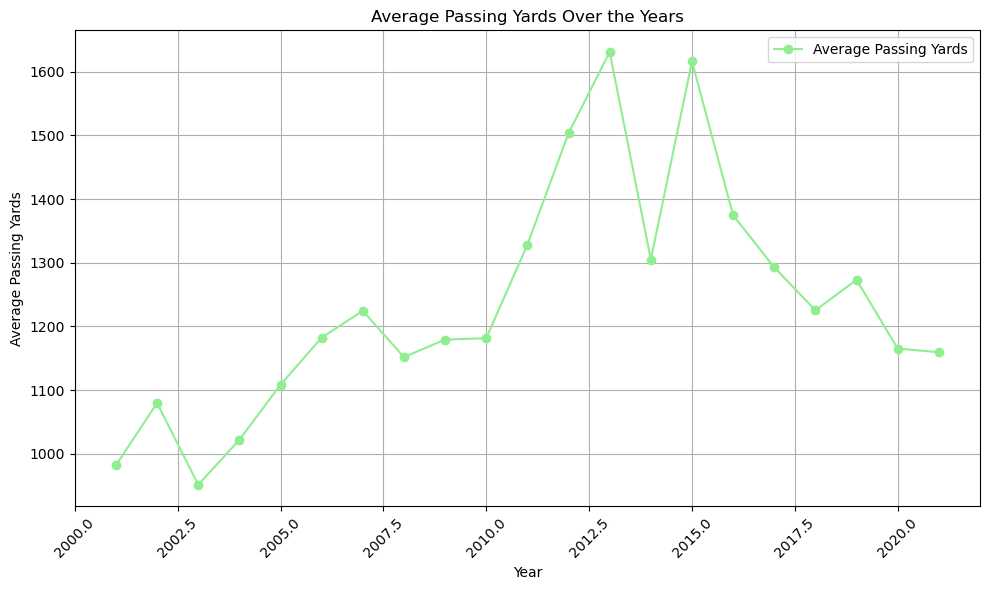

In [86]:
# Calculate average touchdowns and average passing yards per year
avg_touchdowns_per_year = merged_data_encoded.groupby('Year')['TD'].mean()
avg_yards_per_year = merged_data_encoded.groupby('Year')['Yds'].mean()

# Plot line chart for average touchdowns over the years
plt.figure(figsize=(10, 6))
avg_touchdowns_per_year.plot(kind='line', marker='o', color='skyblue', label='Average Touchdowns')
plt.title('Average Touchdowns Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Touchdowns')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot line chart for average passing yards over the years
plt.figure(figsize=(10, 6))
avg_yards_per_year.plot(kind='line', marker='o', color='lightgreen', label='Average Passing Yards')
plt.title('Average Passing Yards Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Passing Yards')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

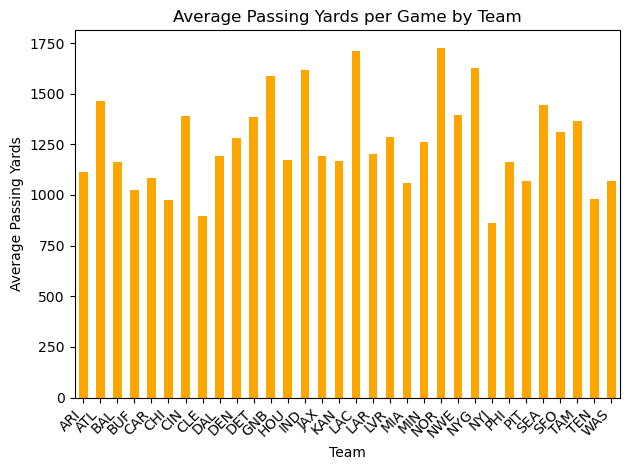

In [87]:
# Average Passing Yards by Team
avg_yards_per_game = merged_data.groupby('Tm')['Yds'].mean()
avg_yards_per_game.plot(kind='bar', color='orange')
plt.title('Average Passing Yards per Game by Team')
plt.xlabel('Team')
plt.ylabel('Average Passing Yards')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

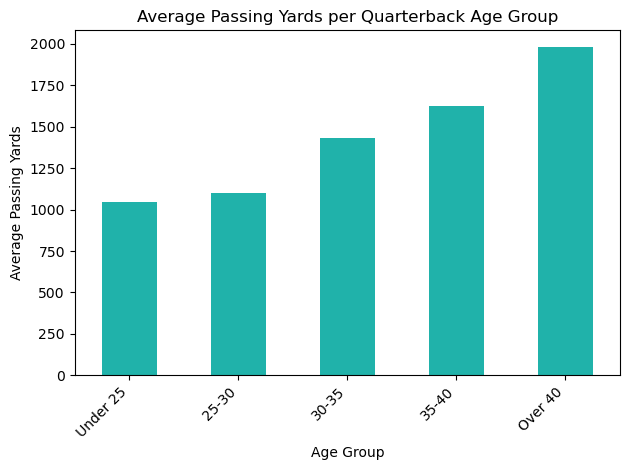

In [88]:
# Calculate average passing yards per age group
bins = [20, 25, 30, 35, 40, 45]
labels = ['Under 25', '25-30', '30-35', '35-40', 'Over 40']
# df1 = merged_data.copy()
df1['Age Group'] = pd.cut(df1['Age'], bins=bins, labels=labels, right=False)
avg_yrds_per_age_group = df1.groupby('Age Group', observed=False)['Yds'].mean()

# Plot bar chart for average passing yards per age group
avg_yrds_per_age_group.plot(kind='bar', color='lightseagreen')
plt.title('Average Passing Yards per Quarterback Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Passing Yards')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

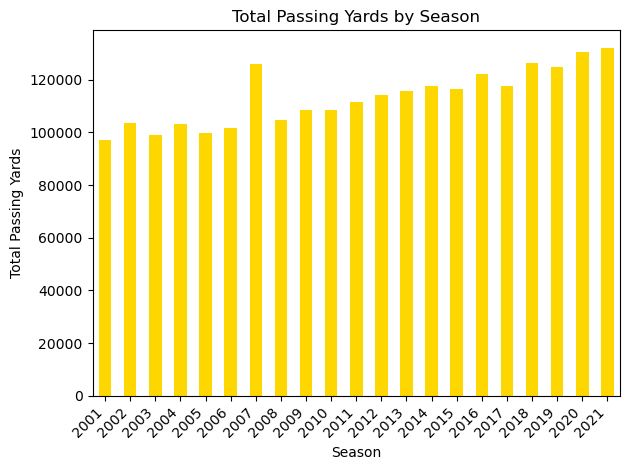

In [89]:
#Comparison of Passing Yards by Season
total_yards_per_season = merged_data.groupby('Year')['Yds'].sum()
total_yards_per_season.plot(kind='bar', color='gold')
plt.title('Total Passing Yards by Season')
plt.xlabel('Season')
plt.ylabel('Total Passing Yards')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()